In this notebook
1) Get data \
    1.1) Read HDF5 \
    1.2) Select only I channel 
2) Filter with moving average
3) Cut data (discard baseline tale) 
4) Filter data (movinga average)
5) Compute second derivative
6) Get cuspid point on x-axis
7) Select 1/8 of total signal lenght for pre trigger

In [92]:
import h5py
import os
import sys
sys.path.append(r'C:\Users\kid\SynologyDrive\Lab2023\KIDs\QTLab2324\IR_SING_PHOT')
from HDF5 import HDF5
import matplotlib.pyplot as plt
import numpy as np
from scipy.signal import savgol_filter, find_peaks
from scipy.optimize import curve_fit
from iminuit import Minuit
from iminuit.cost import LeastSquares

In [93]:
def read(parent):
    data = []
    counter = 0
    for root, dirs, files in os.walk(parent):
        for file in files:
            if file.endswith('.hdf5') and counter<10:
                file_path = os.path.join(root, file)
                f = HDF5.HDF5()
                f.name = file_path
                data.append(f.load_hdf5()['Signals']['I'])
                counter = counter + 1
                print(f'reading file : {counter}')
    return data


In [94]:
data = read(r'C:\Users\kid\SynologyDrive\Lab2023\KIDs\QTLab2324\IR_SING_PHOT\RUNS\10')

Execution time: 1.527
reading file : 1
Execution time: 0.821
reading file : 2
Execution time: 0.733
reading file : 3
Execution time: 0.361
reading file : 4
Execution time: 0.968
reading file : 5
Execution time: 0.35
reading file : 6
Execution time: 0.689
reading file : 7
Execution time: 1.057
reading file : 8
Execution time: 0.31
reading file : 9
Execution time: 0.972
reading file : 10


In [95]:
xmin, ymin = [np.argmin(data[0]) , max(-data[0])]

In [129]:
#idx = [i for i in range(len(data[1])) if (i<int(0.3*1e6) and i>int(0.15*1e6))]
#I = data[1][idx]

I = -data[0][xmin-2000:xmin+20000]
T = np.linspace(xmin-2000,xmin+20000,len(I),dtype=int)

In [130]:
# Apply moving average filter
window_size = 500  # Size of the moving average window
cumsum = np.cumsum(I)
cumsum[window_size:] = cumsum[window_size:] - cumsum[:-window_size]
moving_avg = cumsum[window_size - 1:] / window_size
# Pad the moving average to match the length of the original signal
moving_avg = np.pad(moving_avg, (window_size - 1, 0), mode='constant', constant_values=(moving_avg[0], moving_avg[-1]))

In [131]:
window_length = 171  # Must be odd
polyorder = 3
sg_filtered_signal = savgol_filter(moving_avg, window_length, polyorder)

# Post-processing: Optional further smoothing
window_size = 5
smoothed_signal = np.convolve(sg_filtered_signal, np.ones(window_size)/window_size, mode='valid')

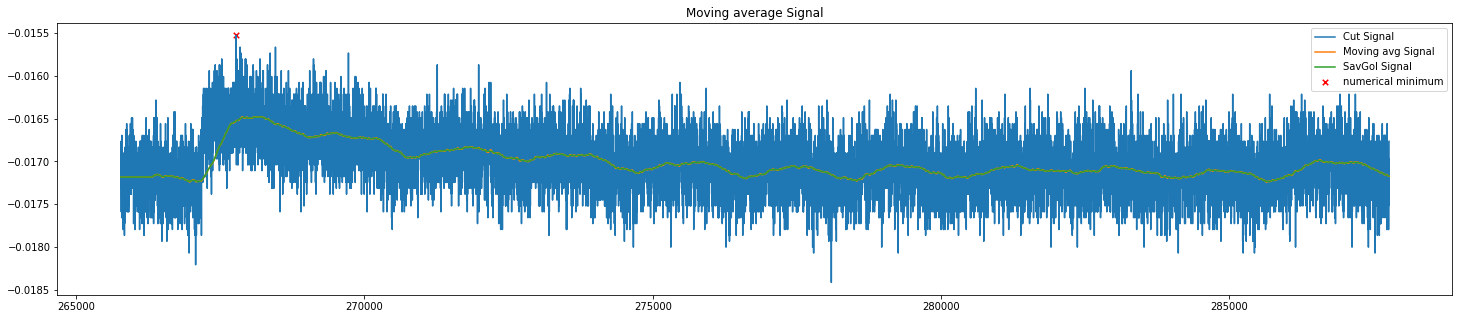

In [132]:
plt.figure(figsize=(25,5))
plt.plot(T, I, label='Cut Signal')
plt.plot(T, moving_avg, label='Moving avg Signal')
plt.plot(T[:len(smoothed_signal)], smoothed_signal, label='SavGol Signal')
plt.scatter(xmin, ymin, marker='x',color='red',s=30,label='numerical minimum')
plt.title('Moving average Signal')
plt.legend()

In [133]:
len_fit = int(np.floor(len(I)/10))
pol_amp = np.polyfit(T[:len_fit], I[:len_fit], 2)
rms = np.sqrt(np.mean((np.polyval(pol_amp, T[:len_fit])-I[:len_fit])**2))   

In [170]:
stima_tau2 = T[max(np.where(smoothed_signal<(max(smoothed_signal)*(1-1/np.e)))[0])]
stima_tau1 = T[min(np.where(smoothed_signal>(min(smoothed_signal)*(1+1/np.e)))[0])]

In [188]:
def model(x, A, t1, tau1, t2, tau2,B):
    return A*(np.exp(-(x-t1)/tau1)-np.exp(-(x-t2)/tau2))+B

In [191]:
p0 = [0.01, 267500, stima_tau2, 268000, stima_tau1,np.mean(T[0:1000])]

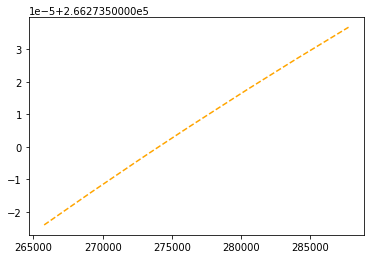

In [192]:
#plt.scatter(T[:len(smoothed_signal)],smoothed_signal,label='smoothed signal',marker='.',s=1,color='black')
plt.plot(T[:len(smoothed_signal)],model(T[:len(smoothed_signal)],*p0),label='Initial guess',linestyle='--',color='orange')

In [174]:
sig = LeastSquares(T[:len(smoothed_signal)],smoothed_signal,rms,model)
msig = Minuit(sig,*p0)
msig.migrad(iterate=1000)

┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 5072 (χ²/ndof = 0.2)       │              Nfcn = 827              │
│ EDM = 0.0247 (Goal: 0.0002)      │            time = 0.7 sec            │
├──────────────────────────────────┼──────────────────────────────────────┤
│         INVALID Minimum          │   Below EDM threshold (goal x 10)    │
├──────────────────────────────────┼──────────────────────────────────────┤
│      No parameters at limit      │           ABOVE call limit           │
├──────────────────────────────────┼──────────────────────────────────────┤
│             Hesse ok             │        Covariance APPROXIMATE        │
└──────────────────────────────────┴──────────────────────────────────────┘
┌───┬──────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼──────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ A    │  -0.114   │   0.004   │            │            │         │         │       │
│ 1 │ t1   │ 281.58e3  │  0.21e3   │            │            │         │         │       │
│ 2 │ tau1 │   177e3   │    6e3    │            │            │         │         │       │
│ 3 │ t2   │ 257.59e3  │  0.30e3   │            │            │         │         │       │
│ 4 │ tau2 │   148e3   │    6e3    │            │            │         │         │       │
└───┴──────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌──────┬────────────────────────────────────────────────────────┐
│      │          A         t1       tau1         t2       tau2 │
├──────┼────────────────────────────────────────────────────────┤
│    A │   1.38e-05 794.465e-3 -22.345843   1.116636 -21.367685 │
│   t1 │ 794.465e-3   4.59e+04    -1.29e6     0.06e6    -1.23e6 │
│ tau1 │ -22.345843    -1.29e6   3.63e+07    -1.81e6    0.035e9 │
│   t2 │   1.116636     0.06e6    -1.81e6   9.07e+04    -1.73e6 │
│ tau2 │ -21.367685    -1.23e6    0.035e9    -1.73e6   3.32e+07 │
└──────┴────────────────────────────────────────────────────────┘

In [150]:
# Calculate the 10% and 90% points of the fitted signal
y_10 = msig.values['D'] + 0.1 * msig.values['A']
y_90 = msig.values['D'] + 0.9 * msig.values['A']

# Find the time at which the signal reaches these values
t_10 = T[np.abs(sigmoid(T[0:3000],*msig.values) - y_10).argmin()]
t_90 = T[np.abs(sigmoid(T[0:3000],*msig.values) - y_90).argmin()]

Text(0.5, 1.0, 'Time constant FIT')

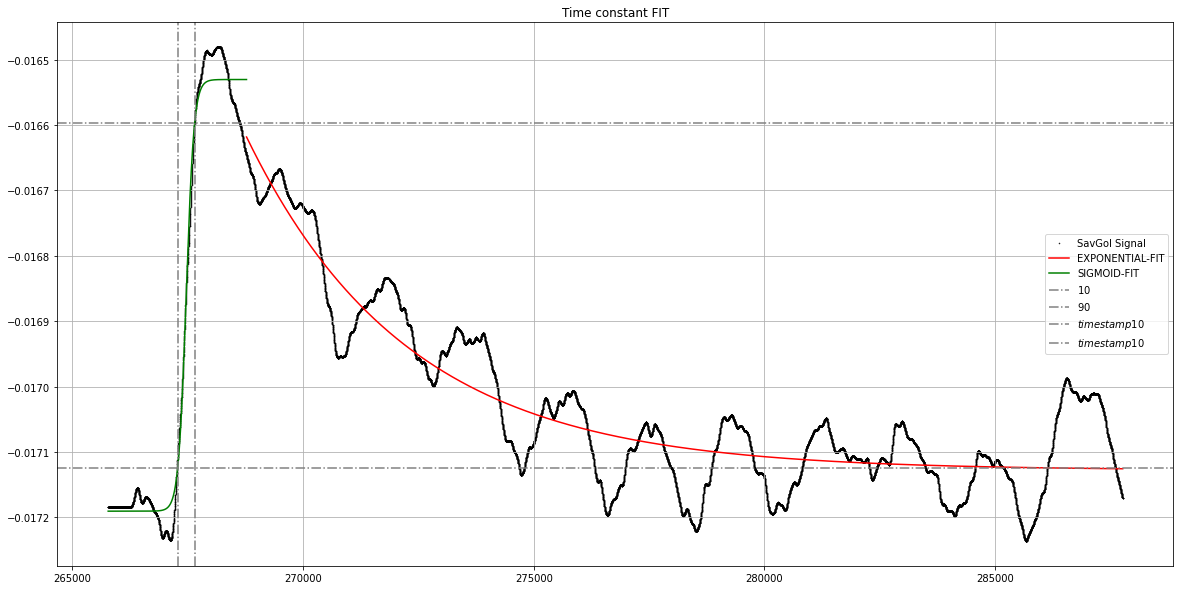

In [152]:
plt.figure(figsize=(20,10))
plt.scatter(T[:len(smoothed_signal)], smoothed_signal, label='SavGol Signal',marker='.',s=1,color='black')

plt.plot(T[3000:len(smoothed_signal)],model(T[3000:len(smoothed_signal)],*mexp.values),label='EXPONENTIAL-FIT',linestyle='-',color='red')
plt.axhline(y_90,0,1,linestyle='-.',label=r'$90 % \hspace{0.1} A$', color='grey')
plt.axvline(t_10,0,1, linestyle='-.',label=r'$time stamp 10 % \hspace{0.1} A$', color='grey')
plt.axvline(t_90,0,1, linestyle='-.',label=r'$time stamp 10 % \hspace{0.1} A$', color='grey')
plt.legend()
plt.grid()
plt.title('Time constant FIT')

In [161]:
# Calculate the rise time
rise_time = t_90 - t_10
print(f"Rise Time: {rise_time:.4f} micro seconds")

Rise Time: 370.0000 micro seconds


In [154]:
fitted_signal = np.array(list(sigmoid(T[0:3000],*msig.values))+list(model(T[3000:],*mexp.values)))

In [155]:
window = 111 
polyorder = 3 
fd = savgol_filter(fitted_signal,window, polyorder, deriv=1) 
sd = savgol_filter(fitted_signal,window, polyorder, deriv=2) 

In [156]:
th = 4*1e-8
peaks, props = find_peaks(sd, th)
peak = peaks[np.argmax(props['peak_heights'])]

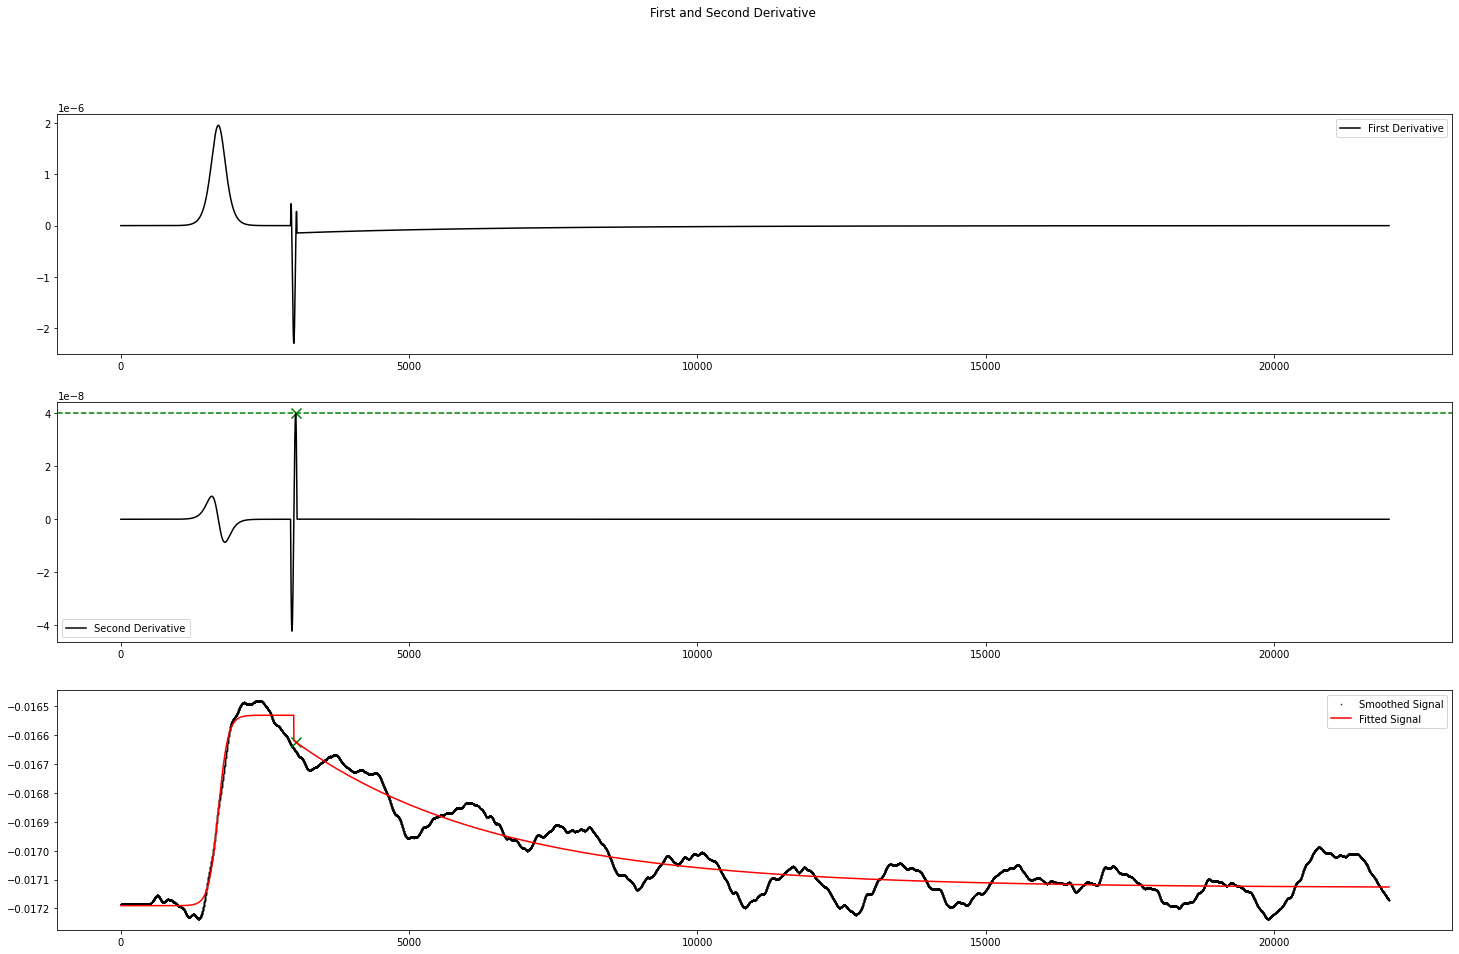

In [159]:
fig, axs = plt.subplots(3,1,figsize=(25,15))
axs[1].plot(np.linspace(0,len(sd),len(sd)),sd,color='black',label='Second Derivative')
axs[0].plot(np.linspace(0,len(fd),len(fd)),fd,color='black',label='First Derivative')
#axs[0].axhline(th, 0, 1, linestyle='--', color='green')
axs[2].scatter(np.linspace(0,len(smoothed_signal),len(smoothed_signal)), smoothed_signal, label='Smoothed Signal',marker='.',color='black',s=1)
axs[2].plot(np.linspace(0,len(fitted_signal),len(fitted_signal)), fitted_signal, label='Fitted Signal',color='red')
axs[1].scatter(peak, max(props['peak_heights']), marker='x', color='green', s=100)
axs[2].scatter(peak, fitted_signal[peak], marker='x', color='green', s=100)
axs[1].axhline(th, 0, 1, linestyle='--', color='green')
fig.suptitle('First and Second Derivative')
axs[0].legend()
axs[1].legend()
axs[2].legend()

In [ ]:
with open('Trigger.txt','a') as file:
    file.writelines('\n'+str(peaks[0])+'\t'+str(props['peak_heights'][0]))

I really have to compute PSD of signal